# 在自己的数据集上训练2D人体关键点检测模型

参考文档：https://github.com/open-mmlab/mmpose/blob/master/demo/MMPose_Tutorial.ipynb

作者：同济子豪兄 2022-06-20

如果报错`CUDA out of memory.`则重启前面几个代码的`kernel`即可。

## 进入 MMPose 主目录

In [1]:
import os
os.chdir('mmpose')
os.listdir()

['.git',
 '.circleci',
 '.dev_scripts',
 '.github',
 '.gitignore',
 '.pre-commit-config.yaml',
 '.pylintrc',
 '.readthedocs.yml',
 'CITATION.cff',
 'LICENSE',
 'MANIFEST.in',
 'README.md',
 'README_CN.md',
 'configs',
 'demo',
 'docker',
 'docs',
 'mmpose',
 'model-index.yml',
 'pytest.ini',
 'requirements.txt',
 'requirements',
 'resources',
 'setup.cfg',
 'setup.py',
 'tests',
 'tools',
 'mmpose.egg-info',
 'checkpoints',
 'outputs',
 'data']

## 导入工具包

In [2]:
import cv2

# 导入可视化工具包 matplotlib，并让绘制的图像嵌入在 notebook 中
import matplotlib.pyplot as plt
%matplotlib inline

# 定义可视化图像函数，输入图像路径，可视化图像
def show_img_from_path(img_path):
    '''opencv 读入图像，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img = cv2.imread(img_path)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()
    
# 定义可视化图像函数，输入图像 array，可视化图像
def show_img_from_array(img):
    '''输入 array，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

## 下载数据集

In [3]:
# 下载数据集压缩包至 data 目录
!wget https://download.openmmlab.com/mmpose/datasets/coco_tiny.tar -O data/coco_tiny.tar

--2022-06-30 17:06:33--  https://download.openmmlab.com/mmpose/datasets/coco_tiny.tar
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 16558080 (16M) [application/octet-stream]
Saving to: ‘data/coco_tiny.tar’

data/coco_tiny.tar  100%[===================>]  15.79M  60.1MB/s    in 0.3s    

2022-06-30 17:06:33 (60.1 MB/s) - ‘data/coco_tiny.tar’ saved [16558080/16558080]



In [4]:
# 进入 data 目录
os.chdir('data')

In [5]:
# 解压
!tar -xf coco_tiny.tar

In [6]:
# 回到 mmpose 目录
os.chdir('../')

## 查看标注文件

In [7]:
import json
import pprint

# 载入训练集标注文件
anns = json.load(open('data/coco_tiny/train.json'))

In [8]:
len(anns)

75

In [9]:
pprint.pprint(anns[0], compact=True)

{'bbox': [267.03, 104.32, 229.19, 320],
 'image_file': '000000537548.jpg',
 'image_size': [640, 480],
 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 325, 160, 2, 398,
               177, 2, 0, 0, 0, 437, 238, 2, 0, 0, 0, 477, 270, 2, 287, 255, 1,
               339, 267, 2, 0, 0, 0, 423, 314, 2, 0, 0, 0, 355, 367, 2]}


demo数据集包含100张来自 COCO train2017数据集的图像，训练集75张，测试集25张。

## 将数据集转为 mmpose 支持的类

把自己的关键点检测数据集，使用 mmpose 训练，有两种方法。

方法一：直接将数据集标注转为 mmpose 支持的数据集格式（例如 COCO）。在 mmpose 中使用对应的数据集类（例如 TopdownCOCODataset）训练。文档：https://mmpose.readthedocs.io/en/latest/tutorials/2_new_dataset.html#reorganize-dataset-to-existing-format

方法二：如果你自己的关键点检测数据集的标注格式与标准数据集（例如 COCO）不同。那么，需要手动写一个新的数据集类。在类中，读取标注文件内容并整理为一个 sample list，并实现数据集的 evaluate 接口。

以下展示方法二。

In [10]:
import json
import os.path as osp
from collections import OrderedDict
import tempfile

import numpy as np

from mmpose.core.evaluation.top_down_eval import (keypoint_nme,
                                                  keypoint_pck_accuracy)
from mmpose.datasets.builder import DATASETS
from mmpose.datasets.datasets.base import Kpt2dSviewRgbImgTopDownDataset


@DATASETS.register_module()
class TopDownCOCOTinyDataset(Kpt2dSviewRgbImgTopDownDataset):

    def __init__(self,
                 ann_file,
                 img_prefix,
                 data_cfg,
                 pipeline,
                 dataset_info=None,
                 test_mode=False):
        super().__init__(
            ann_file,
            img_prefix,
            data_cfg,
            pipeline,
            dataset_info,
            coco_style=False,
            test_mode=test_mode)

        # flip_pairs, upper_body_ids and lower_body_ids will be used
        # in some data augmentations like random flip
        self.ann_info['flip_pairs'] = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10],
                                       [11, 12], [13, 14], [15, 16]]
        self.ann_info['upper_body_ids'] = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
        self.ann_info['lower_body_ids'] = (11, 12, 13, 14, 15, 16)

        self.ann_info['joint_weights'] = None
        self.ann_info['use_different_joint_weights'] = False

        self.dataset_name = 'coco_tiny'
        self.db = self._get_db()

    def _get_db(self):
        with open(self.ann_file) as f:
            anns = json.load(f)

        db = []
        for idx, ann in enumerate(anns):
            # get image path
            image_file = osp.join(self.img_prefix, ann['image_file'])
            # get bbox
            bbox = ann['bbox']
            # get keypoints
            keypoints = np.array(
                ann['keypoints'], dtype=np.float32).reshape(-1, 3)
            num_joints = keypoints.shape[0]
            joints_3d = np.zeros((num_joints, 3), dtype=np.float32)
            joints_3d[:, :2] = keypoints[:, :2]
            joints_3d_visible = np.zeros((num_joints, 3), dtype=np.float32)
            joints_3d_visible[:, :2] = np.minimum(1, keypoints[:, 2:3])

            sample = {
                'image_file': image_file,
                'bbox': bbox,
                'rotation': 0,
                'joints_3d': joints_3d,
                'joints_3d_visible': joints_3d_visible,
                'bbox_score': 1,
                'bbox_id': idx,
            }
            db.append(sample)

        return db

    def evaluate(self, results, res_folder=None, metric='PCK', **kwargs):
        """Evaluate keypoint detection results. The pose prediction results will
        be saved in `${res_folder}/result_keypoints.json`.

        Note:
        batch_size: N
        num_keypoints: K
        heatmap height: H
        heatmap width: W

        Args:
        results (list(preds, boxes, image_path, output_heatmap))
            :preds (np.ndarray[N,K,3]): The first two dimensions are
                coordinates, score is the third dimension of the array.
            :boxes (np.ndarray[N,6]): [center[0], center[1], scale[0]
                , scale[1],area, score]
            :image_paths (list[str]): For example, ['Test/source/0.jpg']
            :output_heatmap (np.ndarray[N, K, H, W]): model outputs.

        res_folder (str, optional): The folder to save the testing
                results. If not specified, a temp folder will be created.
                Default: None.
        metric (str | list[str]): Metric to be performed.
            Options: 'PCK', 'NME'.

        Returns:
            dict: Evaluation results for evaluation metric.
        """
        metrics = metric if isinstance(metric, list) else [metric]
        allowed_metrics = ['PCK', 'NME']
        for metric in metrics:
            if metric not in allowed_metrics:
                raise KeyError(f'metric {metric} is not supported')

        if res_folder is not None:
            tmp_folder = None
            res_file = osp.join(res_folder, 'result_keypoints.json')
        else:
            tmp_folder = tempfile.TemporaryDirectory()
            res_file = osp.join(tmp_folder.name, 'result_keypoints.json')

        kpts = []
        for result in results:
            preds = result['preds']
            boxes = result['boxes']
            image_paths = result['image_paths']
            bbox_ids = result['bbox_ids']

            batch_size = len(image_paths)
            for i in range(batch_size):
                kpts.append({
                    'keypoints': preds[i].tolist(),
                    'center': boxes[i][0:2].tolist(),
                    'scale': boxes[i][2:4].tolist(),
                    'area': float(boxes[i][4]),
                    'score': float(boxes[i][5]),
                    'bbox_id': bbox_ids[i]
                })
        kpts = self._sort_and_unique_bboxes(kpts)

        self._write_keypoint_results(kpts, res_file)
        info_str = self._report_metric(res_file, metrics)
        name_value = OrderedDict(info_str)

        if tmp_folder is not None:
            tmp_folder.cleanup()

        return name_value

    def _report_metric(self, res_file, metrics, pck_thr=0.3):
        """Keypoint evaluation.

        Args:
        res_file (str): Json file stored prediction results.
        metrics (str | list[str]): Metric to be performed.
            Options: 'PCK', 'NME'.
        pck_thr (float): PCK threshold, default: 0.3.

        Returns:
        dict: Evaluation results for evaluation metric.
        """
        info_str = []

        with open(res_file, 'r') as fin:
            preds = json.load(fin)
        assert len(preds) == len(self.db)

        outputs = []
        gts = []
        masks = []

        for pred, item in zip(preds, self.db):
            outputs.append(np.array(pred['keypoints'])[:, :-1])
            gts.append(np.array(item['joints_3d'])[:, :-1])
            masks.append((np.array(item['joints_3d_visible'])[:, 0]) > 0)

        outputs = np.array(outputs)
        gts = np.array(gts)
        masks = np.array(masks)

        normalize_factor = self._get_normalize_factor(gts)

        if 'PCK' in metrics:
            _, pck, _ = keypoint_pck_accuracy(outputs, gts, masks, pck_thr,
                                              normalize_factor)
            info_str.append(('PCK', pck))

        if 'NME' in metrics:
            info_str.append(
                ('NME', keypoint_nme(outputs, gts, masks, normalize_factor)))

        return info_str

    @staticmethod
    def _write_keypoint_results(keypoints, res_file):
        """Write results into a json file."""

        with open(res_file, 'w') as f:
            json.dump(keypoints, f, sort_keys=True, indent=4)

    @staticmethod
    def _sort_and_unique_bboxes(kpts, key='bbox_id'):
        """sort kpts and remove the repeated ones."""
        kpts = sorted(kpts, key=lambda x: x[key])
        num = len(kpts)
        for i in range(num - 1, 0, -1):
            if kpts[i][key] == kpts[i - 1][key]:
                del kpts[i]

        return kpts

    @staticmethod
    def _get_normalize_factor(gts):
        """Get inter-ocular distance as the normalize factor, measured as the
        Euclidean distance between the outer corners of the eyes.

        Args:
            gts (np.ndarray[N, K, 2]): Groundtruth keypoint location.

        Return:
            np.ndarray[N, 2]: normalized factor
        """

        interocular = np.linalg.norm(
            gts[:, 0, :] - gts[:, 1, :], axis=1, keepdims=True)
        return np.tile(interocular, [1, 2])

## 创建 config 配置文件

In [11]:
from mmcv import Config

# 模型 config 配置文件
cfg = Config.fromfile('./configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/hrnet_w32_coco_256x192.py')

# 基础配置
cfg.data_root = 'data/coco_tiny'
cfg.work_dir = 'work_dirs/hrnet_w32_coco_tiny_256x192'
cfg.gpu_ids = range(1)
cfg.seed = 0

# 日志间隔
cfg.log_config.interval = 1

# 评估指标
cfg.evaluation.interval = 10
cfg.evaluation.metric = 'PCK'
cfg.evaluation.save_best = 'PCK'

# 学习率和训练策略
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=10,
    warmup_ratio=0.001,
    step=[17, 35])
cfg.total_epochs = 40

# batch size
cfg.data.samples_per_gpu = 16
cfg.data.val_dataloader = dict(samples_per_gpu=16)
cfg.data.test_dataloader = dict(samples_per_gpu=16)

# 数据集配置
cfg.data.train.type = 'TopDownCOCOTinyDataset'
cfg.data.train.ann_file = f'{cfg.data_root}/train.json'
cfg.data.train.img_prefix = f'{cfg.data_root}/images/'

cfg.data.val.type = 'TopDownCOCOTinyDataset'
cfg.data.val.ann_file = f'{cfg.data_root}/val.json'
cfg.data.val.img_prefix = f'{cfg.data_root}/images/'

cfg.data.test.type = 'TopDownCOCOTinyDataset'
cfg.data.test.ann_file = f'{cfg.data_root}/val.json'
cfg.data.test.img_prefix = f'{cfg.data_root}/images/'

In [12]:
print(cfg.pretty_text)

checkpoint_config = dict(interval=10)
log_config = dict(interval=1, hooks=[dict(type='TextLoggerHook')])
log_level = 'INFO'
load_from = None
resume_from = None
dist_params = dict(backend='nccl')
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
dataset_info = dict(
    dataset_name='coco',
    paper_info=dict(
        author=
        'Lin, Tsung-Yi and Maire, Michael and Belongie, Serge and Hays, James and Perona, Pietro and Ramanan, Deva and Doll{\'a}r, Piotr and Zitnick, C Lawrence',
        title='Microsoft coco: Common objects in context',
        container='European conference on computer vision',
        year='2014',
        homepage='http://cocodataset.org/'),
    keypoint_info=dict({
        0:
        dict(name='nose', id=0, color=[51, 153, 255], type='upper', swap=''),
        1:
        dict(
            name='left_eye',
            id=1,
            color=[51, 153, 255],
            type='upper',
            swap='right_eye'),
        2:
        dict

## 训练

In [13]:
from mmpose.datasets import build_dataset
from mmpose.models import build_posenet
from mmpose.apis import train_model
import mmcv

# build 数据集
datasets = [build_dataset(cfg.data.train)]

# build 模型
model = build_posenet(cfg.model)

# 创建 work_dir 目录
mmcv.mkdir_or_exist(cfg.work_dir)

# train model
train_model(model, datasets, cfg, distributed=False, validate=True, meta=dict())

load checkpoint from http path: https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w32-36af842e.pth


Downloading: "https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w32-36af842e.pth" to /home/featurize/.cache/torch/hub/checkpoints/hrnet_w32-36af842e.pth


  0%|          | 0.00/126M [00:00<?, ?B/s]

2022-06-30 17:07:26,652 - mmpose - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.0.0.0.conv1.weight, head.0.0.0.bn1.weight, head.0.0.0.bn1.bias, head.0.0.0.bn1.running_mean, head.0.0.0.bn1.running_var, head.0.0.0.bn1.num_batches_tracked, head.0.0.0.conv2.weight, head.0.0.0.bn2.weight, head.0.0.0.bn2.bias, head.0.0.0.bn2.running_mean, head.0.0.0.bn2.running_var, head.0.0.0.bn2.num_batches_tracked, head.0.0.0.conv3.weight, head.0.0.0.bn3.weight, head.0.0.0.bn3.bias, head.0.0.0.bn3.running_mean, head.0.0.0.bn3.running_var, head.0.0.0.bn3.num_batches_tracked, head.0.0.0.downsample.0.weight, head.0.0.0.downsample.1.weight, head.0.0.0.downsample.1.bias, head.0.0.0.downsample.1.running_mean, head.0.0.0.downsample.1.running_var, head.0.0.0.downsample.1.num_batches_tracked, head.0.1.0.conv1.weight, head.0.1.0.bn1.weight, head.0.1.0.bn1.bias, head.0.1.0.bn1.running_mean, head.0.1.0.bn1.running_var, head.0.1.0.bn1.num_batches_tracked, he

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 41.1 task/s, elapsed: 1s, ETA:     0s

2022-06-30 17:08:15,848 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_10.pth.
2022-06-30 17:08:15,850 - mmpose - INFO - Best PCK is 0.0908 at 10 epoch.
2022-06-30 17:08:15,851 - mmpose - INFO - Epoch(val) [10][2]	PCK: 0.0908
2022-06-30 17:08:18,581 - mmpose - INFO - Epoch [11][1/5]	lr: 5.045e-05, eta: 0:02:00, time: 2.721, data_time: 2.359, memory: 2919, heatmap_loss: 0.0020, acc_pose: 0.1041, loss: 0.0020
2022-06-30 17:08:18,883 - mmpose - INFO - Epoch [11][2/5]	lr: 5.145e-05, eta: 0:01:58, time: 0.302, data_time: 0.008, memory: 2919, heatmap_loss: 0.0020, acc_pose: 0.1756, loss: 0.0020
2022-06-30 17:08:19,187 - mmpose - INFO - Epoch [11][3/5]	lr: 5.245e-05, eta: 0:01:56, time: 0.304, data_time: 0.004, memory: 2919, heatmap_loss: 0.0019, acc_pose: 0.1845, loss: 0.0019
2022-06-30 17:08:19,483 - mmpose - INFO - Epoch [11][4/5]	lr: 5.345e-05, eta: 0:01:53, time: 0.297, data_time: 0.005, memory: 2919, heatmap_loss: 0.0020, acc_pose: 0.1937, loss: 0.0020
2022-06-30 17:08

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 42.7 task/s, elapsed: 1s, ETA:     0s

2022-06-30 17:08:57,107 - mmpose - INFO - The previous best checkpoint /home/featurize/work/MMPose教程/mmpose/work_dirs/hrnet_w32_coco_tiny_256x192/best_PCK_epoch_10.pth was removed
2022-06-30 17:08:58,363 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_20.pth.
2022-06-30 17:08:58,365 - mmpose - INFO - Best PCK is 0.1445 at 20 epoch.
2022-06-30 17:08:58,365 - mmpose - INFO - Epoch(val) [20][2]	PCK: 0.1445
2022-06-30 17:09:01,058 - mmpose - INFO - Epoch [21][1/5]	lr: 1.004e-04, eta: 0:01:18, time: 2.686, data_time: 2.347, memory: 2919, heatmap_loss: 0.0016, acc_pose: 0.3239, loss: 0.0016
2022-06-30 17:09:01,335 - mmpose - INFO - Epoch [21][2/5]	lr: 1.014e-04, eta: 0:01:16, time: 0.278, data_time: 0.006, memory: 2919, heatmap_loss: 0.0014, acc_pose: 0.2498, loss: 0.0014
2022-06-30 17:09:01,608 - mmpose - INFO - Epoch [21][3/5]	lr: 1.024e-04, eta: 0:01:15, time: 0.272, data_time: 0.004, memory: 2919, heatmap_loss: 0.0018, acc_pose: 0.3578, loss: 0.0018
2022-06-30 17:09:01,8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 42.5 task/s, elapsed: 1s, ETA:     0s

2022-06-30 17:09:39,702 - mmpose - INFO - The previous best checkpoint /home/featurize/work/MMPose教程/mmpose/work_dirs/hrnet_w32_coco_tiny_256x192/best_PCK_epoch_20.pth was removed
2022-06-30 17:09:41,130 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_30.pth.
2022-06-30 17:09:41,132 - mmpose - INFO - Best PCK is 0.1814 at 30 epoch.
2022-06-30 17:09:41,133 - mmpose - INFO - Epoch(val) [30][2]	PCK: 0.1814
2022-06-30 17:09:43,848 - mmpose - INFO - Epoch [31][1/5]	lr: 1.504e-04, eta: 0:00:38, time: 2.708, data_time: 2.361, memory: 2919, heatmap_loss: 0.0015, acc_pose: 0.4000, loss: 0.0015
2022-06-30 17:09:44,150 - mmpose - INFO - Epoch [31][2/5]	lr: 1.513e-04, eta: 0:00:37, time: 0.302, data_time: 0.006, memory: 2919, heatmap_loss: 0.0016, acc_pose: 0.4381, loss: 0.0016
2022-06-30 17:09:44,446 - mmpose - INFO - Epoch [31][3/5]	lr: 1.523e-04, eta: 0:00:36, time: 0.296, data_time: 0.004, memory: 2919, heatmap_loss: 0.0016, acc_pose: 0.3846, loss: 0.0016
2022-06-30 17:09:44,7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 38.5 task/s, elapsed: 1s, ETA:     0s

2022-06-30 17:10:22,553 - mmpose - INFO - Epoch(val) [40][2]	PCK: 0.1753


## 使用训练得到的模型预测（和B1代码一致）

In [14]:
from mmpose.apis import inference_top_down_pose_model, init_pose_model, vis_pose_result, process_mmdet_results
from mmdet.apis import inference_detector, init_detector

### 指定模型`config`配置文件和`checkpoint`权重文件

In [15]:
# 目标检测模型
det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 人体姿态估计模型
pose_config = 'configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/hrnet_w48_coco_256x192.py'
pose_checkpoint = 'work_dirs/hrnet_w32_coco_tiny_256x192/latest.pth'


### 初始化模型

In [16]:
# 目标检测模型
det_model = init_detector(det_config, det_checkpoint)

# 人体姿态估计模型
pose_model = init_pose_model(cfg, pose_checkpoint)


load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
load checkpoint from local path: work_dirs/hrnet_w32_coco_tiny_256x192/latest.pth


### 执行预测

In [17]:
# img_path = 'data/TongjiDancer.png'
img_path = 'tests/data/coco/000000196141.jpg'

mmdet_results = inference_detector(det_model, img_path)

# 提取类别 ID 为 1 的 行人 目标检测框
person_results = process_mmdet_results(mmdet_results, cat_id=1)

pose_results, returned_outputs = inference_top_down_pose_model(pose_model, img_path, person_results, bbox_thr=0.3, format='xyxy', dataset='TopDownCocoDataset')

vis_result = vis_pose_result(pose_model, img_path, pose_results, dataset='TopDownCocoDataset', show=False)

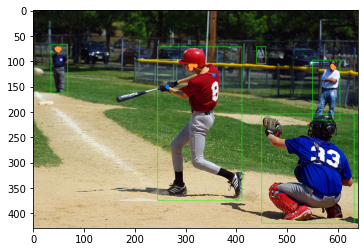

In [18]:
show_img_from_array(vis_result)

In [19]:
cv2.imwrite('outputs/B4.jpg', vis_result)

True